In [1]:
! pip install gdown

In [2]:
! gdown https://drive.google.com/u/3/uc?id=12KuQHhOcp_9VyCzPzN8BQ9NjJR8AN34Z

Downloading...
From: https://drive.google.com/u/3/uc?id=12KuQHhOcp_9VyCzPzN8BQ9NjJR8AN34Z
To: /content/building_segmentation.zip
727MB [00:11, 62.3MB/s]


In [3]:
! unzip -qq building_segmentation.zip

In [4]:
#! unzip -qq roads.zip
import os
import numpy as np
import cv2
import glob
#from glob import glob
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision 
from tensorflow.keras import backend as K


In [5]:
img_training_files = glob.glob('building_segmentation/training/input/*')
img_training_masks = glob.glob('building_segmentation/training/output/*')
img_validation_files = glob.glob('building_segmentation/validation/input/*')
img_validation_masks = glob.glob('building_segmentation/validation/output/*')
img_testing_files = glob.glob('building_segmentation/testing/input/*')
img_testing_masks = glob.glob('building_segmentation/testing/output/*')



In [6]:
img_training_files.sort()
img_training_masks.sort()
print(len(img_training_files))
print(len(img_training_masks))
print(len(img_validation_files))
print(len(img_validation_masks))
print(img_training_files[:10])
print(img_training_masks[:10])
print(len(img_testing_files))
print(len(img_testing_masks))

136
136
3
3
['building_segmentation/training/input/img-1.png', 'building_segmentation/training/input/img-10.png', 'building_segmentation/training/input/img-100.png', 'building_segmentation/training/input/img-101.png', 'building_segmentation/training/input/img-102.png', 'building_segmentation/training/input/img-103.png', 'building_segmentation/training/input/img-104.png', 'building_segmentation/training/input/img-105.png', 'building_segmentation/training/input/img-106.png', 'building_segmentation/training/input/img-107.png']
['building_segmentation/training/output/img-1.png', 'building_segmentation/training/output/img-10.png', 'building_segmentation/training/output/img-100.png', 'building_segmentation/training/output/img-101.png', 'building_segmentation/training/output/img-102.png', 'building_segmentation/training/output/img-103.png', 'building_segmentation/training/output/img-104.png', 'building_segmentation/training/output/img-105.png', 'building_segmentation/training/output/img-106.p

In [7]:
for i in range(136,136+9):
  img_file = 'building_segmentation/testing/input/img-{}.png'.format(i-135)
  mask_file = 'building_segmentation/testing/output/img-{}.png'.format(i-135)
  img_f = cv2.imread(img_file,cv2.IMREAD_UNCHANGED)
  img_m = cv2.imread(mask_file,cv2.IMREAD_UNCHANGED)
  out_img_file_name = 'building_segmentation/training/input/img-{}.png'.format(i)
  out_img_mask_name = 'building_segmentation/training/output/img-{}.png'.format(i)
  cv2.imwrite(out_img_file_name, img_f)
  cv2.imwrite(out_img_mask_name, img_m)
  
  print(out_img_file_name)
  print(out_img_mask_name)
  #break

building_segmentation/training/input/img-136.png
building_segmentation/training/output/img-136.png
building_segmentation/training/input/img-137.png
building_segmentation/training/output/img-137.png
building_segmentation/training/input/img-138.png
building_segmentation/training/output/img-138.png
building_segmentation/training/input/img-139.png
building_segmentation/training/output/img-139.png
building_segmentation/training/input/img-140.png
building_segmentation/training/output/img-140.png
building_segmentation/training/input/img-141.png
building_segmentation/training/output/img-141.png
building_segmentation/training/input/img-142.png
building_segmentation/training/output/img-142.png
building_segmentation/training/input/img-143.png
building_segmentation/training/output/img-143.png
building_segmentation/training/input/img-144.png
building_segmentation/training/output/img-144.png


In [8]:
for i in range(145,145+3):
  img_file = 'building_segmentation/validation/input/img-{}.png'.format(i-144)
  mask_file = 'building_segmentation/validation/output/img-{}.png'.format(i-144)
  img_f = cv2.imread(img_file,cv2.IMREAD_UNCHANGED)
  img_m = cv2.imread(mask_file,cv2.IMREAD_UNCHANGED)
  out_img_file_name = 'building_segmentation/training/input/img-{}.png'.format(i)
  out_img_mask_name = 'building_segmentation/training/output/img-{}.png'.format(i)
  cv2.imwrite(out_img_file_name, img_f)
  cv2.imwrite(out_img_mask_name, img_m)
  
  print(out_img_file_name)
  print(out_img_mask_name)
  #break

building_segmentation/training/input/img-145.png
building_segmentation/training/output/img-145.png
building_segmentation/training/input/img-146.png
building_segmentation/training/output/img-146.png
building_segmentation/training/input/img-147.png
building_segmentation/training/output/img-147.png


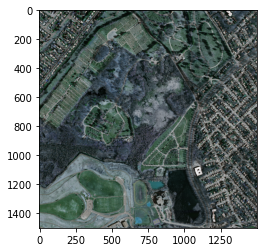

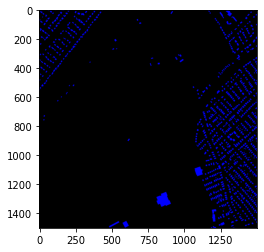

In [9]:
import cv2
img = cv2.imread(img_training_files[0])
plt.imshow(img)
plt.show()
img = cv2.imread(img_training_masks[0])
plt.imshow(img)

In [10]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

IMG_SIZE = 256
EPOCHS = 10
BATCH = 32
LR = 1e-4


PATH = ''

In [16]:
def load_data(path, split=0.1):

  images_list = sorted(glob.glob(os.path.join(path, "building_segmentation/training/input/*")))
  masks_list = sorted(glob.glob(os.path.join(path, "building_segmentation/training/output/*")))

  tot_size = len(images_list)
  val_size = int(split * tot_size)
  test_size = int(split * tot_size)

  x_train, x_val = train_test_split(images_list, test_size=val_size, random_state=42)
  y_train, y_val = train_test_split(masks_list, test_size=val_size, random_state=42)
  x_train, x_test = train_test_split(x_train, test_size=test_size, random_state=42)
  y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [17]:
def read_img(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_COLOR)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    return tmp

def read_mask(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    tmp = np.expand_dims(tmp, axis=-1)
    return tmp

In [18]:
def tf_parse(a, b):
    def _parse(a, b):
        a = read_img(a)
        b = read_mask(b)
        return a, b

    a, b = tf.numpy_function(_parse, [a, b], [tf.float64, tf.float64])
    a.set_shape([IMG_SIZE, IMG_SIZE, 3])
    b.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return a, b

def tf_dataset(a, b, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a, b))
    data = data.map(tf_parse)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [19]:

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data("")

print("Training data: ", len(x_train))
print("Validation data: ", len(x_val))
print("Testing data: ", len(x_test))

Training data:  119
Validation data:  14
Testing data:  14


In [20]:
def read_and_rgb(a):
    a = cv2.imread(a)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

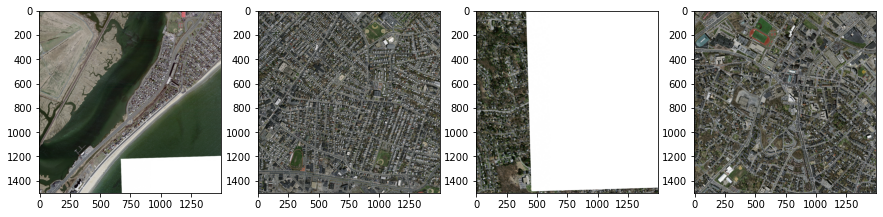

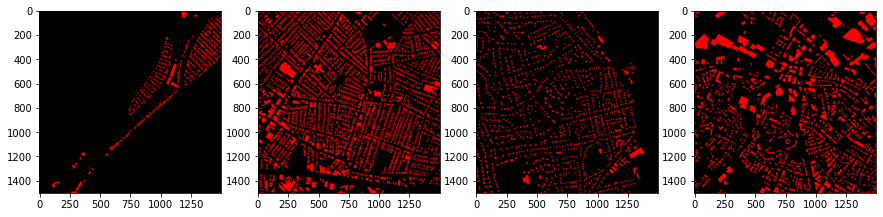

In [21]:
fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(x_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(x_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(x_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(x_train[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(y_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(y_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(y_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(y_train[3]))
imgplot.set_clim(0.0, 1.4)

In [22]:
def model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.50)
    skip_connection_list = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    fil = [48, 64, 96, 128]
    xt = encoder_output
    for i in range(1, len(skip_connection_list)+1, 1):
        xt_skip = encoder.get_layer(skip_connection_list[-i]).output
        xt = UpSampling2D((2, 2))(xt)
        xt = Concatenate()([xt, xt_skip])
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
    xt = Conv2D(1, (1, 1), padding="same")(xt)
    xt = Activation("sigmoid")(xt)
    
    model = Model(inputs, xt)
    return model

In [23]:
model = model()
model.summary()

3203072/3201480 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
________________________

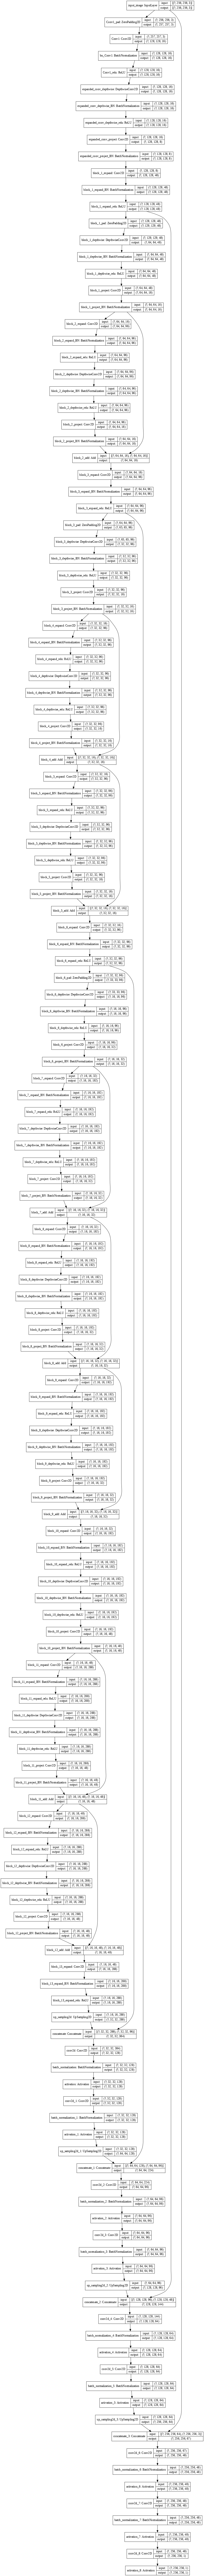

In [24]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [25]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [26]:
train_data = tf_dataset(x_train, y_train, batch=BATCH)
valid_data = tf_dataset(x_val, y_val, batch=BATCH)

In [27]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [28]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir=logdir)
]

In [29]:
train_steps = len(x_train)//BATCH
valid_steps = len(x_val)//BATCH

if len(x_train) % BATCH != 0:
    train_steps += 1
if len(x_val) % BATCH != 0:
    valid_steps += 1

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/10
1/4 [======>.......................] - ETA: 0s - loss: 0.9195 - dice_coef: 0.0805 - recall: 0.2510 - precision: 0.1929WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4/4 [==============================] - ETA: 0s - loss: 0.9190 - dice_coef: 0.0814 - recall: 0.3071 - precision: 0.2061WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INF

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()
plt.savefig('acc_MassachusettsBuildingDetectionUNet.png')

In [ ]:
model.save_weights("UNetMassaBuilding_150e.h5")

model.save("UnetMassaBuilding_with_weight_150e.h5")


In [ ]:
# Run this module only while loading the pre-trained model.
model = load_model('UnetMassaBuilding_with_weight_150e.h5',custom_objects={'dice_loss': dice_loss,'dice_coef':dice_coef})
model.summary()


In [ ]:
test_data = tf_dataset(x_test, y_test, batch=BATCH)

test_steps = (len(x_test)//BATCH)
if len(x_test) % BATCH != 0:
    test_steps += 1

model.evaluate(test_data, steps=test_steps)



In [ ]:
def read_img(path):
    xt = cv2.imread(path, cv2.IMREAD_COLOR)
    xt = cv2.cvtColor(xt, cv2.COLOR_BGR2RGB)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = xt/255.0
    return xt

def read_mask(path):
    xt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = np.expand_dims(xt, axis=-1)
    xt = xt/255.0
    return xt

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
for i, (a, b) in enumerate(zip(x_test[10:30], y_test[10:30])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] > 0.5
    #print(y_pred.shape)
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))
    mask_red = np.ones((h,w,3))
    mask_red[:,:,0] = a[:,:,0]*.5
    mask_red[:,:,1] = a[:,:,1]*0.5 
    mask_red[:,:,2] = y_pred[:,:,0]*.5 + a[:,:,2]*0.5  
    mask_red = mask_red*2
    mask_red = np.clip(mask_red, 0, 1)
    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_red
        #mask_parse(y_pred)*0.5+a*0.5
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
